In [1]:
import os
if '_cwd_set' not in locals(): locals()['_cwd_set'] = os.chdir(os.path.dirname(os.getcwd()))
import omnifig as fig
fig.initialize()
from src.jimports import *
from src.util import set_default_device, repo_root, data_root
torch.set_grad_enabled(False);
device = set_default_device();

Selecting CUDA device 3 with 42316 MiB free memory and 97% utilization


In [2]:
import numpy as np
import random

import clip
from diffusers import DiffusionPipeline, StableDiffusionPipeline
from transformers import CLIPProcessor, CLIPModel
import torch

In [3]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
# model, preprocess = clip.load('ViT-L/14', device)
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model.to(device);

In [16]:
prompt = "brown dog on green grass"
tokens = clip.tokenize([prompt]).to(device)
# with torch.no_grad():
#     text_features = model.encode_text(tokens)
text_features = model.get_text_features(tokens)[0]
text_features.shape

torch.Size([768])

In [17]:
full = model.text_model(tokens).last_hidden_state[0]
full.shape

torch.Size([77, 768])

In [39]:
default = full[tokens[0]==0].mean(0)
default.shape

torch.Size([768])

In [25]:
pipe.encode_prompt(prompt, device, 1, False)[0].shape

torch.Size([1, 77, 768])

In [44]:
injection = torch.cat([default.unsqueeze(0).repeat(76, 1), text_features.unsqueeze(0)],0).unsqueeze(0)
injection.shape

torch.Size([1, 77, 768])

  0%|          | 0/50 [00:00<?, ?it/s]

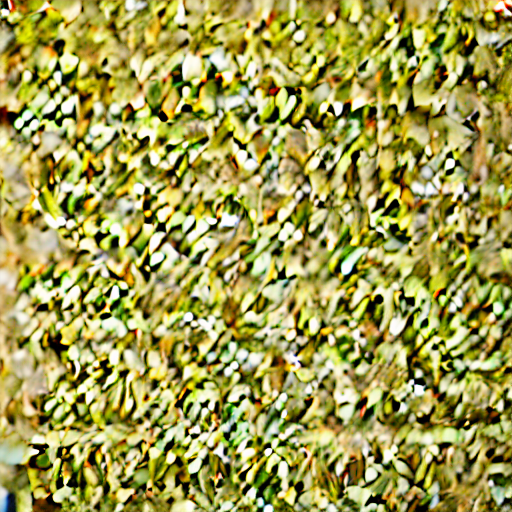

In [45]:
image = pipe(None, prompt_embeds=injection).images[0]
image

In [7]:
text = clip.tokenize(["brown dog on green grass"]).to(device)

In [10]:
with torch.no_grad():
    out = model.text_model(text)
out.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [12]:
out.last_hidden_state.shape

torch.Size([1, 77, 768])

In [6]:
pipe

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.1",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/50 [00:00<?, ?it/s]

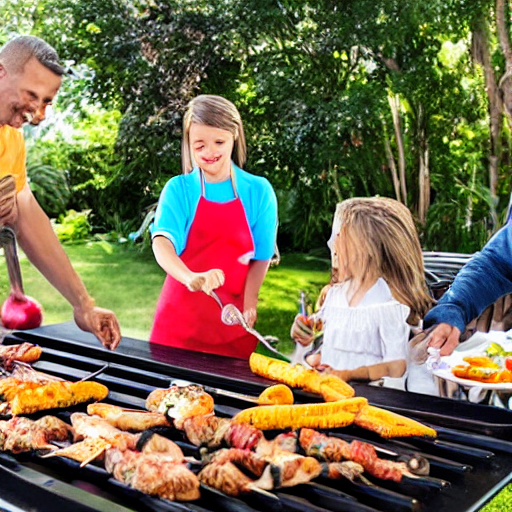

In [7]:
prompt = "for a celebration, this family prepaeres tons of food on the grill"
with torch.no_grad():
    image = pipe(prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

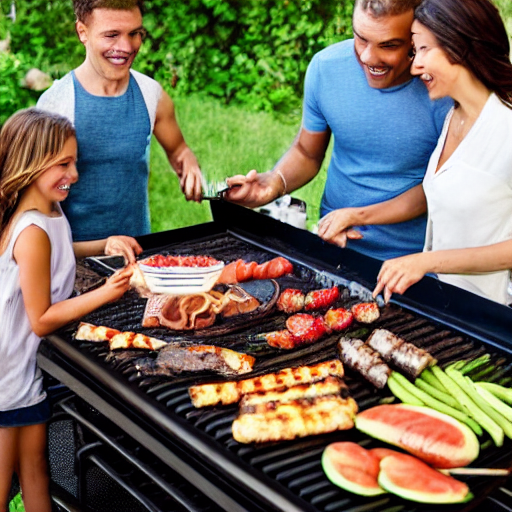

In [8]:
with torch.no_grad():
    image = pipe(None, prompt_embeds=pipe.encode_prompt(prompt, device, 1, False)[0]).images[0]
image

In [9]:
with torch.no_grad():
    cond = model.encode_text(clip.tokenize([prompt]).to(device))
full_cond = cond.unsqueeze(1).repeat(1, 77, 1)
full_cond.shape

torch.Size([1, 77, 768])

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


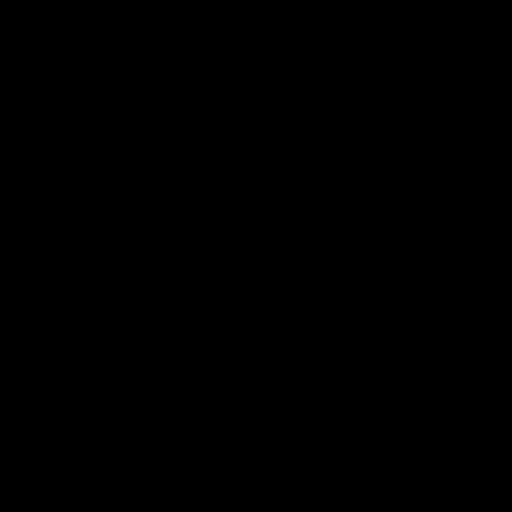

In [10]:
with torch.no_grad():
    image = pipe(None, prompt_embeds=full_cond).images[0]
image

In [11]:
import inspect
from typing import Any, Callable, Dict, List, Optional, Union

import torch
from packaging import version
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer, CLIPVisionModelWithProjection

from diffusers.callbacks import MultiPipelineCallbacks, PipelineCallback
from diffusers.configuration_utils import FrozenDict
from diffusers.image_processor import PipelineImageInput, VaeImageProcessor
from diffusers.loaders import FromSingleFileMixin, IPAdapterMixin, StableDiffusionLoraLoaderMixin, TextualInversionLoaderMixin
from diffusers.models import AutoencoderKL, ImageProjection, UNet2DConditionModel
from diffusers.models.lora import adjust_lora_scale_text_encoder
from diffusers.schedulers import KarrasDiffusionSchedulers
from diffusers.utils import (
    USE_PEFT_BACKEND,
    deprecate,
    is_torch_xla_available,
    logging,
    replace_example_docstring,
    scale_lora_layers,
    unscale_lora_layers,
)
from diffusers.utils.torch_utils import randn_tensor
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, StableDiffusionMixin
from diffusers.pipelines.stable_diffusion.pipeline_output import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import retrieve_timesteps, rescale_noise_cfg

def manual_fn(
        self,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.Tensor] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        ip_adapter_image: Optional[PipelineImageInput] = None,
        ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[
            Union[Callable[[int, int, Dict], None], PipelineCallback, MultiPipelineCallbacks]
        ] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        **kwargs,
    ):
        r"""
        The call function to the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide image generation. If not defined, you need to pass `prompt_embeds`.
            height (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to `self.unet.config.sample_size * self.vae_scale_factor`):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            timesteps (`List[int]`, *optional*):
                Custom timesteps to use for the denoising process with schedulers which support a `timesteps` argument
                in their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is
                passed will be used. Must be in descending order.
            sigmas (`List[float]`, *optional*):
                Custom sigmas to use for the denoising process with schedulers which support a `sigmas` argument in
                their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is passed
                will be used.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                A higher guidance scale value encourages the model to generate images closely linked to the text
                `prompt` at the expense of lower image quality. Guidance scale is enabled when `guidance_scale > 1`.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide what to not include in image generation. If not defined, you need to
                pass `negative_prompt_embeds` instead. Ignored when not using guidance (`guidance_scale < 1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) from the [DDIM](https://arxiv.org/abs/2010.02502) paper. Only applies
                to the [`~schedulers.DDIMScheduler`], and is ignored in other schedulers.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                A [`torch.Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make
                generation deterministic.
            latents (`torch.Tensor`, *optional*):
                Pre-generated noisy latents sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor is generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs (prompt weighting). If not
                provided, text embeddings are generated from the `prompt` input argument.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs (prompt weighting). If
                not provided, `negative_prompt_embeds` are generated from the `negative_prompt` input argument.
            ip_adapter_image: (`PipelineImageInput`, *optional*): Optional image input to work with IP Adapters.
            ip_adapter_image_embeds (`List[torch.Tensor]`, *optional*):
                Pre-generated image embeddings for IP-Adapter. It should be a list of length same as number of
                IP-adapters. Each element should be a tensor of shape `(batch_size, num_images, emb_dim)`. It should
                contain the negative image embedding if `do_classifier_free_guidance` is set to `True`. If not
                provided, embeddings are computed from the `ip_adapter_image` input argument.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generated image. Choose between `PIL.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            cross_attention_kwargs (`dict`, *optional*):
                A kwargs dictionary that if specified is passed along to the [`AttentionProcessor`] as defined in
                [`self.processor`](https://github.com/huggingface/diffusers/blob/main/src/diffusers/models/attention_processor.py).
            guidance_rescale (`float`, *optional*, defaults to 0.0):
                Guidance rescale factor from [Common Diffusion Noise Schedules and Sample Steps are
                Flawed](https://arxiv.org/pdf/2305.08891.pdf). Guidance rescale factor should fix overexposure when
                using zero terminal SNR.
            clip_skip (`int`, *optional*):
                Number of layers to be skipped from CLIP while computing the prompt embeddings. A value of 1 means that
                the output of the pre-final layer will be used for computing the prompt embeddings.
            callback_on_step_end (`Callable`, `PipelineCallback`, `MultiPipelineCallbacks`, *optional*):
                A function or a subclass of `PipelineCallback` or `MultiPipelineCallbacks` that is called at the end of
                each denoising step during the inference. with the following arguments: `callback_on_step_end(self:
                DiffusionPipeline, step: int, timestep: int, callback_kwargs: Dict)`. `callback_kwargs` will include a
                list of all tensors as specified by `callback_on_step_end_tensor_inputs`.
            callback_on_step_end_tensor_inputs (`List`, *optional*):
                The list of tensor inputs for the `callback_on_step_end` function. The tensors specified in the list
                will be passed as `callback_kwargs` argument. You will only be able to include variables listed in the
                `._callback_tensor_inputs` attribute of your pipeline class.

        Examples:

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] is returned,
                otherwise a `tuple` is returned where the first element is a list with the generated images and the
                second element is a list of `bool`s indicating whether the corresponding generated image contains
                "not-safe-for-work" (nsfw) content.
        """

        callback = kwargs.pop("callback", None)
        callback_steps = kwargs.pop("callback_steps", None)

        if callback is not None:
            deprecate(
                "callback",
                "1.0.0",
                "Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
            )
        if callback_steps is not None:
            deprecate(
                "callback_steps",
                "1.0.0",
                "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
            )

        if isinstance(callback_on_step_end, (PipelineCallback, MultiPipelineCallbacks)):
            callback_on_step_end_tensor_inputs = callback_on_step_end.tensor_inputs

        # 0. Default height and width to unet
        if not height or not width:
            height = (
                self.unet.config.sample_size
                if self._is_unet_config_sample_size_int
                else self.unet.config.sample_size[0]
            )
            width = (
                self.unet.config.sample_size
                if self._is_unet_config_sample_size_int
                else self.unet.config.sample_size[1]
            )
            height, width = height * self.vae_scale_factor, width * self.vae_scale_factor
        # to deal with lora scaling and other possible forward hooks

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            height,
            width,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
            ip_adapter_image,
            ip_adapter_image_embeds,
            callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._guidance_rescale = guidance_rescale
        self._clip_skip = clip_skip
        self._cross_attention_kwargs = cross_attention_kwargs
        self._interrupt = False

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # 3. Encode input prompt
        lora_scale = (
            self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None
        )

        prompt_embeds, negative_prompt_embeds = self.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            self.do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=lora_scale,
            clip_skip=self.clip_skip,
        )

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
            image_embeds = self.prepare_ip_adapter_image_embeds(
                ip_adapter_image,
                ip_adapter_image_embeds,
                device,
                batch_size * num_images_per_prompt,
                self.do_classifier_free_guidance,
            )

        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps, sigmas
        )

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 6.1 Add image embeds for IP-Adapter
        added_cond_kwargs = (
            {"image_embeds": image_embeds}
            if (ip_adapter_image is not None or ip_adapter_image_embeds is not None)
            else None
        )

        # 6.2 Optionally get Guidance Scale Embedding
        timestep_cond = None
        if self.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            timestep_cond = self.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        self._num_timesteps = len(timesteps)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if self.interrupt:
                    continue

                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    timestep_cond=timestep_cond,
                    cross_attention_kwargs=self.cross_attention_kwargs,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if self.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + self.guidance_scale * (noise_pred_text - noise_pred_uncond)

                if self.do_classifier_free_guidance and self.guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=self.guidance_rescale)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

                # if XLA_AVAILABLE:
                #     xm.mark_step()

        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False, generator=generator)[
                0
            ]
            # image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
            has_nsfw_concept = None
        else:
            image = latents
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]
        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)

  0%|          | 0/50 [00:00<?, ?it/s]

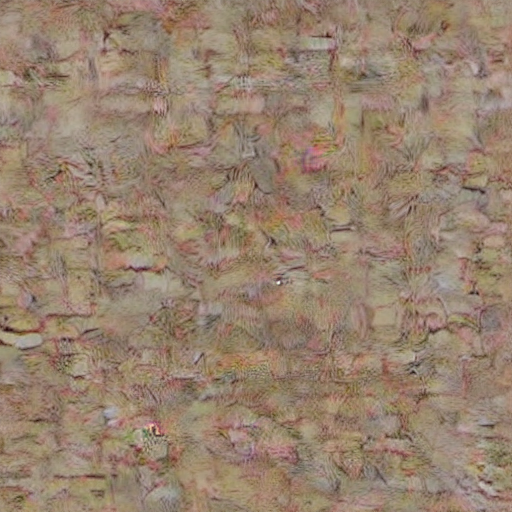

In [12]:
with torch.no_grad():
    image = manual_fn(pipe, None, prompt_embeds=full_cond).images[0]
image

In [31]:
with torch.no_grad():
    out = pipe.encode_prompt(prompt, device, 1, False)
out[0].shape

torch.Size([1, 77, 768])

In [ ]:
pipe.text_encoder(clip.tokenize([prompt]).to(device)).last_hidden_state.shape

In [23]:
model.encode_text(clip.tokenize([prompt]).to(device)).shape

torch.Size([1, 768])

In [42]:
clip.tokenize([prompt])

tensor([[49406,   556,   320,  4615,   267,   589,  1315, 26270, 15751,  7555,
           539,  1559,   525,   518,  9519, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [41]:
clip.tokenize([prompt]).argmax(dim=-1)

tensor([15])

In [40]:
model.encode_text()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


In [39]:
model.text_projection.shape

torch.Size([768, 768])

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_repo_id = "stabilityai/stable-diffusion-3.5-medium"

In [3]:
if torch.cuda.is_available():
    torch_dtype = torch.bfloat16
else:
    torch_dtype = torch.float32

pipe = DiffusionPipeline.from_pretrained(model_repo_id, torch_dtype=torch_dtype)
pipe = pipe.to(device)

MAX_SEED = np.iinfo(np.int32).max
MAX_IMAGE_SIZE = 1440

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


  0%|          | 0/40 [00:00<?, ?it/s]

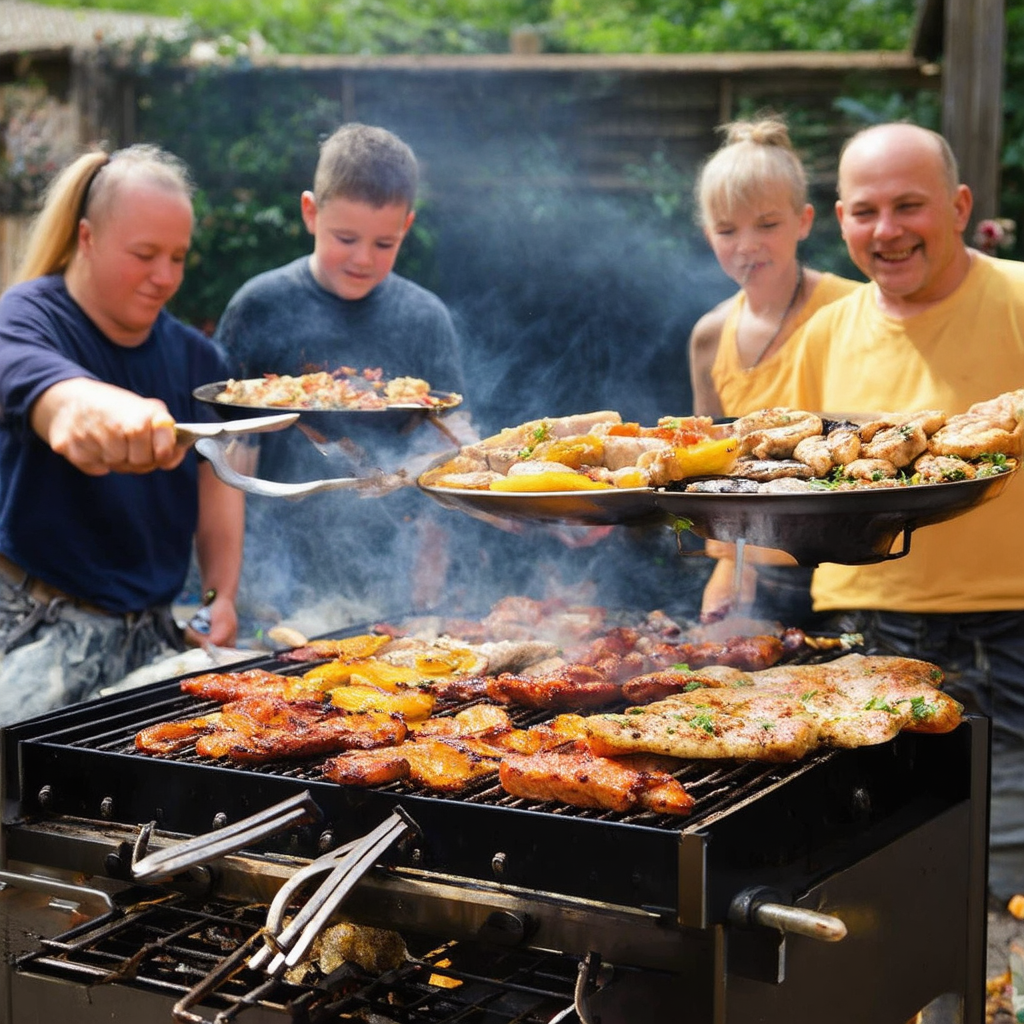

In [10]:
image = pipe(
    "for a celebration, this family prepaeres tons of food on the grill",
    num_inference_steps=40,
    guidance_scale=4.5,
).images[0]
image
# image.save("capybara.png")